# Importing libraries

In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
from skimage import io, transform
from sklearn import preprocessing
import joblib
import cv2
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import PassiveAggressiveClassifier
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from skimage.transform import resize
from skimage.io import imread

# Target categories : Safe,Unsafe

In [2]:
path = r"C:\Users\pavankalyan\Desktop\B15-Work place saftey\DATA SET(Worksite Safety Monitoring)"
MODEL_DIR = "models"
RESULTS_DIR = "results"
IMG_SIZE = (64, 64)

os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(RESULTS_DIR, exist_ok=True)

categories = sorted([
    d for d in os.listdir(path)
    if os.path.isdir(os.path.join(path, d)) and not d.startswith('.')
])


print("Detected classes:", categories)


Detected classes: ['safe', 'unsafe']


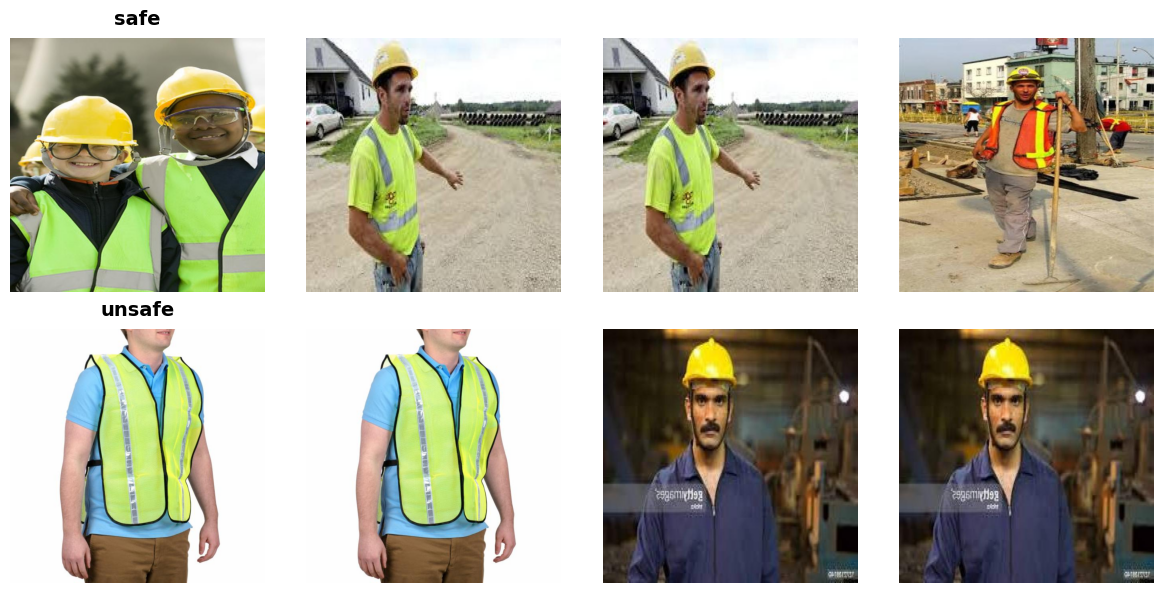

Final image saved at: results\classes_grid.png


In [3]:
num_classes = len(categories)
num_cols = 4  # 4 images per class

# Create results folder if it doesn't exist
results_folder = r"results"
os.makedirs(results_folder, exist_ok=True)

plt.figure(figsize=(num_cols * 3, num_classes * 3))

for i, category in enumerate(categories):
    folder_path = os.path.join(path, category)
    files = [f for f in os.listdir(folder_path) if f.lower().endswith(("jpg", "jpeg", "png")) and 'Thumbs.db' not in f]
    
    selected_files = files[:4]  # pick 4 images per class
    
    for j, file in enumerate(selected_files):
        img_path = os.path.join(folder_path, file)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # BGR → RGB
        
        ax = plt.subplot(num_classes, num_cols, i * num_cols + j + 1)
        ax.imshow(img)
        ax.axis('off')
        
        # Add class name as a title above the first image of each row
        if j == 0:
            ax.set_title(category, fontsize=14, weight='bold', pad=10, loc='center')

plt.tight_layout()

# Save the final image
output_path = os.path.join(results_folder, "classes_grid.png")
plt.savefig(output_path, dpi=300, bbox_inches='tight')
plt.show()

print(f"Final image saved at: {output_path}")

# Features extraction (HOG)

In [4]:
from skimage.feature import hog, local_binary_pattern
IMG_SIZE = (64, 64)

def extract_features(img):
    img = cv2.resize(img, IMG_SIZE)

    # ── Shape (HOG)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    hog_feat = hog(
        gray,
        orientations=9,
        pixels_per_cell=(8, 8),
        cells_per_block=(2, 2),
        block_norm="L2-Hys"
    )

    # ── Texture (LBP)
    lbp = local_binary_pattern(gray, P=8, R=1, method="uniform")
    lbp_hist, _ = np.histogram(lbp.ravel(), bins=59, range=(0, 59))
    lbp_hist = lbp_hist.astype("float")
    lbp_hist /= (lbp_hist.sum() + 1e-6)

    # ── Color (HSV)
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h_hist = cv2.calcHist([hsv], [0], None, [30], [0, 180])
    s_hist = cv2.calcHist([hsv], [1], None, [32], [0, 256])
    v_hist = cv2.calcHist([hsv], [2], None, [32], [0, 256])

    color_hist = np.concatenate([h_hist, s_hist, v_hist]).flatten()
    color_hist /= (color_hist.sum() + 1e-6)

    return np.hstack([hog_feat, lbp_hist, color_hist])


# X And Y Separation

In [5]:
model_folder =  "models"
X_file = os.path.join(model_folder, "X.txt.npy")
Y_file = os.path.join(model_folder, "Y.txt.npy")

if os.path.exists(X_file) and os.path.exists(Y_file):
    X = np.load(X_file)
    Y = np.load(Y_file)
    print("X and Y arrays loaded successfully.")
else:
    X = []  # input array
    Y = []  # output array
    for root, dirs, directory in os.walk(path):
        for j in range(len(directory)):
            name = os.path.basename(root)
            print(f'Loading category: {dirs}')
            print(name+" "+root+"/"+directory[j])
            
            if 'Thumbs.db' not in directory[j]:
                img_array = cv2.imread(root+"/"+directory[j])
                
                # Resize image
                img_resized = cv2.resize(img_array, IMG_SIZE)

                # Extract HOG + LBP + HSV features
                features = extract_features(img_resized)

                # Append feature vector to X
                X.append(features)
                
                # Append label to Y
                Y.append(categories.index(name))

    X = np.array(X)
    Y = np.array(Y)
    np.save(X_file, X)
    np.save(Y_file, Y)


X and Y arrays loaded successfully.


In [6]:
df = pd.DataFrame(X)
df['Labels'] = Y
df

,0,1,2,3,4,5,6,7,8,9,...,1908,1909,1910,1911,1912,1913,1914,1915,1916,Labels
0,0.325775,0.317487,0.010347,0.018584,0.101566,0.038281,0.006186,0.003957,0.016523,0.325775,...,0.005208,0.004150,0.004476,0.006022,0.010498,0.021647,0.046387,0.024740,0.012126,0
1,0.206902,0.009288,0.014934,0.035025,0.044123,0.031698,0.359508,0.208813,0.107498,0.013170,...,0.040365,0.054525,0.033936,0.012858,0.006917,0.006022,0.006185,0.004476,0.054932,0
2,0.206902,0.009288,0.014934,0.035025,0.044123,0.031698,0.359508,0.208813,0.107498,0.013170,...,0.040365,0.054525,0.033936,0.012858,0.006917,0.006022,0.006185,0.004476,0.054932,0
3,0.007865,0.000000,0.000000,0.019997,0.119614,0.030216,0.008090,0.004177,0.000000,0.046226,...,0.032552,0.047282,0.039307,0.026611,0.016927,0.003337,0.002848,0.003743,0.006104,0
4,0.007865,0.000000,0.000000,0.019997,0.119614,0.030216,0.008090,0.004177,0.000000,0.046226,...,0.032552,0.047282,0.039307,0.026611,0.016927,0.003337,0.002848,0.003743,0.006104,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1988,0.290149,0.165321,0.031846,0.290149,0.193816,0.082797,0.100105,0.107731,0.290149,0.290149,...,0.006185,0.005046,0.004801,0.003825,0.001139,0.000570,0.000081,0.000407,0.000895,1
1989,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.003255,0.004639,0.004639,0.003988,0.004150,0.004232,0.005859,0.008301,0.236247,1
1990,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.003255,0.004639,0.004639,0.003988,0.004150,0.004232,0.005859,0.008301,0.236247,1
1991,0.045112,0.084126,0.182978,0.164650,0.076132,0.075947,0.016545,0.015829,0.004667,0.008968,...,0.009196,0.007487,0.007975,0.006917,0.007161,0.008952,0.011637,0.009603,0.092448,1


In [7]:

df.Labels.unique()

array([0, 1])

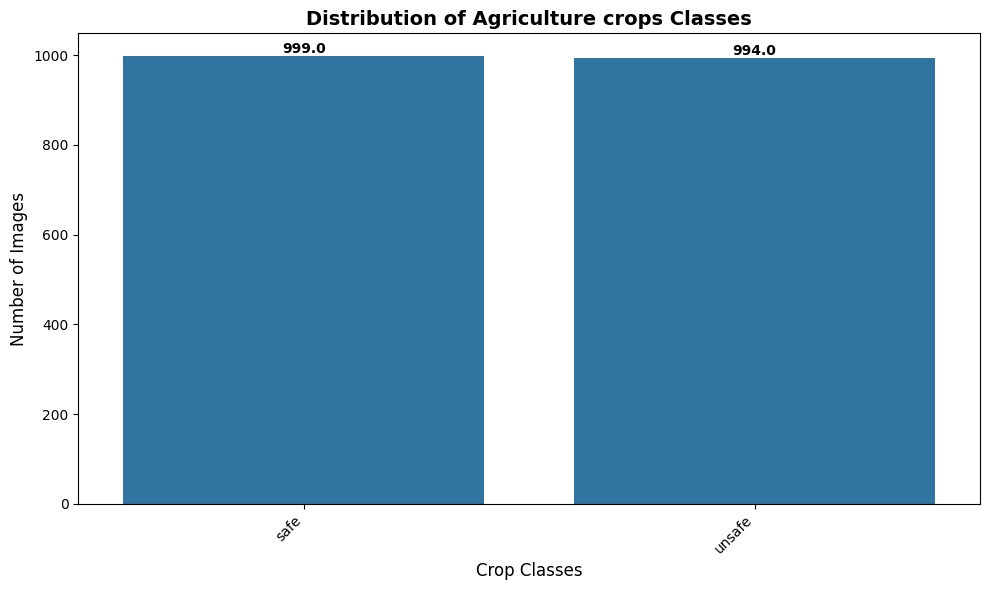

In [8]:
plt.figure(figsize=(10, 6))
ax = sns.countplot(x=Y)

# Replace x-ticks with class names automatically
ax.set_xticklabels(categories, rotation=45, ha='right')

# Add value labels on top of each bar
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height}', (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.xlabel("Crop Classes", fontsize=12)
plt.ylabel("Number of Images", fontsize=12)
plt.title("Distribution of Agriculture crops Classes", fontsize=14, weight='bold')
plt.tight_layout()
plt.show()

In [9]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Split the data
x_train, x_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.2, random_state=77, stratify=Y
)

# Apply SMOTE on training data only
#sm = SMOTE()
#x_train, y_train = sm.fit_resample(x_train, y_train)

print("x_train:", x_train.shape)
print("y_train:", y_train.shape)

x_train: (1594, 1917)
y_train: (1594,)


# Performance Evaluation

In [10]:

# ──────────────────────────────────────────────────────────────
# Global containers
# ──────────────────────────────────────────────────────────────
metrics_overall = []                    # Overall metrics
class_metrics_storage = {}              # Key = class name → list of dicts (one per model)
def calculateMetrics(algorithm, predict, testY):
    """
    Call this for every model (RFC, DTC, NBC, etc.)
    """
    testY = testY.astype('int')
    predict = predict.astype('int')
    
    # ── Overall metrics ─────────────────────────────────────
    acc  = accuracy_score(testY, predict) * 100
    prec = precision_score(testY, predict, average='macro', zero_division=0) * 100
    rec  = recall_score(testY, predict, average='macro', zero_division=0) * 100
    f1   = f1_score(testY, predict, average='macro', zero_division=0) * 100
    
    metrics_overall.append({
        'Model': algorithm,
        'Accuracy':  round(acc, 2),
        'Precision': round(prec, 2),
        'Recall':    round(rec, 2),
        'F1-Score':  round(f1, 2)
    })
    
    print(f"\n=== {algorithm} Overall ===")
    print(f"Accuracy  : {acc:.2f}%")
    print(f"Precision : {prec:.2f}%")
    print(f"Recall    : {rec:.2f}%")
    print(f"F1-Score  : {f1:.2f}%\n")
    
    # ── Class-wise metrics ──────────────────────────────────
    report = classification_report(testY, predict, target_names=categories,
                                  output_dict=True, zero_division=0)
    print("\n=== Classification Report ===")
    print(classification_report(testY, predict, target_names=categories, zero_division=0))

    for cls in categories:
        # Initialize list for this class if first time
        if cls not in class_metrics_storage:
            class_metrics_storage[cls] = []
        
        class_metrics_storage[cls].append({
            'Model':     algorithm,
            'Precision': round(report[cls]['precision'] * 100, 2),
            'Recall':    round(report[cls]['recall'] * 100, 2),
            'F1-Score':  round(report[cls]['f1-score'] * 100, 2)
        })
    
    # ── Confusion matrix ────────────────────────────────────
    cm = confusion_matrix(testY, predict)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=categories, yticklabels=categories, cbar=False)
    plt.title(f"{algorithm} - Confusion Matrix")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

# Modelbuilding And Training

# Support Vector Classifier



=== SVC Overall ===
Accuracy  : 85.46%
Precision : 85.48%
Recall    : 85.47%
F1-Score  : 85.46%


=== Classification Report ===
              precision    recall  f1-score   support

        safe       0.86      0.84      0.85       200
      unsafe       0.85      0.86      0.86       199

    accuracy                           0.85       399
   macro avg       0.85      0.85      0.85       399
weighted avg       0.85      0.85      0.85       399



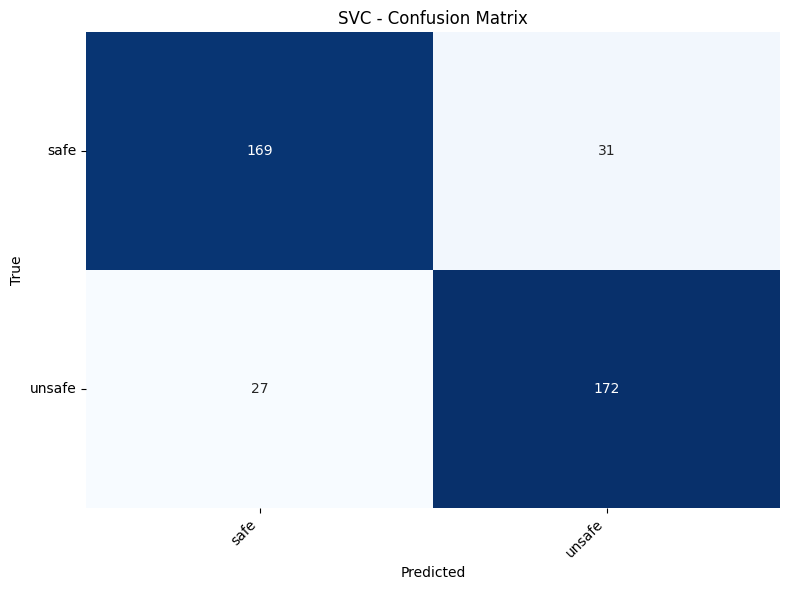

In [11]:
from sklearn.svm import SVC

model_path = r"models\SVC.pkl"

os.makedirs(os.path.dirname(model_path), exist_ok=True)

if os.path.exists(model_path) and os.path.getsize(model_path) > 0:
    svc_clf = joblib.load(model_path)
    predict = svc_clf.predict(x_test)
    calculateMetrics("SVC", predict, y_test)

else:
    svc_clf= SVC(max_iter=1000)
    svc_clf.fit(x_train, y_train)
    predict = svc_clf.predict(x_test)
    joblib.dump(svc_clf, model_path)
    calculateMetrics("SVC", predict, y_test)

# Nearest centroid


===  NearestCentroid Overall ===
Accuracy  : 60.40%
Precision : 60.47%
Recall    : 60.41%
F1-Score  : 60.34%


=== Classification Report ===
              precision    recall  f1-score   support

        safe       0.61      0.56      0.59       200
      unsafe       0.60      0.64      0.62       199

    accuracy                           0.60       399
   macro avg       0.60      0.60      0.60       399
weighted avg       0.60      0.60      0.60       399



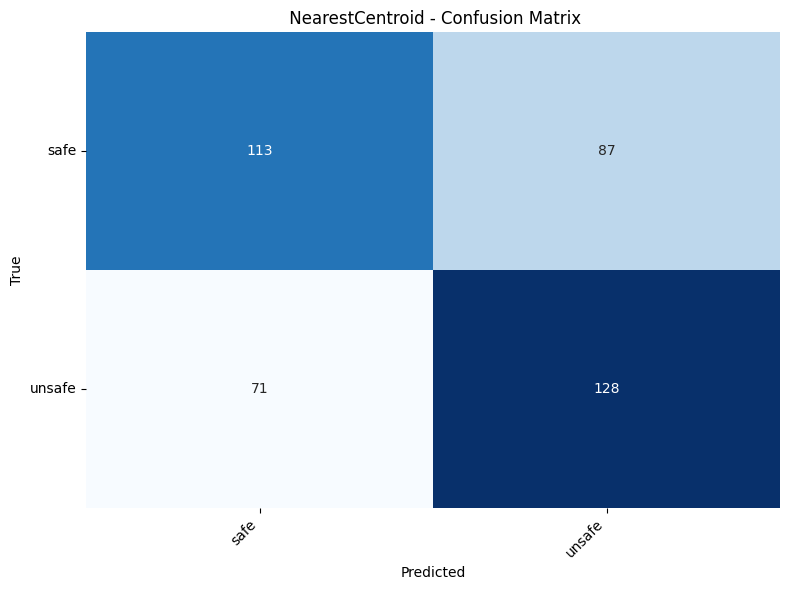

In [12]:
from sklearn.neighbors import NearestCentroid
model_path = r"models\ NearestCentroid.pkl"

os.makedirs(os.path.dirname(model_path), exist_ok=True)

if os.path.exists(model_path) and os.path.getsize(model_path) > 0:
    nc_clf = joblib.load(model_path)
    predict = nc_clf.predict(x_test)
    calculateMetrics(" NearestCentroid", predict, y_test)

else:
    nc_clf = NearestCentroid()
    nc_clf.fit(x_train, y_train)
    predict = nc_clf.predict(x_test)
    joblib.dump(nc_clf, model_path)
    calculateMetrics(" NearestCentroid", predict, y_test)

# Gaussian Process Classifier


=== GaussianProcessClassifier Overall ===
Accuracy  : 86.22%
Precision : 87.10%
Recall    : 86.23%
F1-Score  : 86.14%


=== Classification Report ===
              precision    recall  f1-score   support

        safe       0.93      0.79      0.85       200
      unsafe       0.81      0.94      0.87       199

    accuracy                           0.86       399
   macro avg       0.87      0.86      0.86       399
weighted avg       0.87      0.86      0.86       399



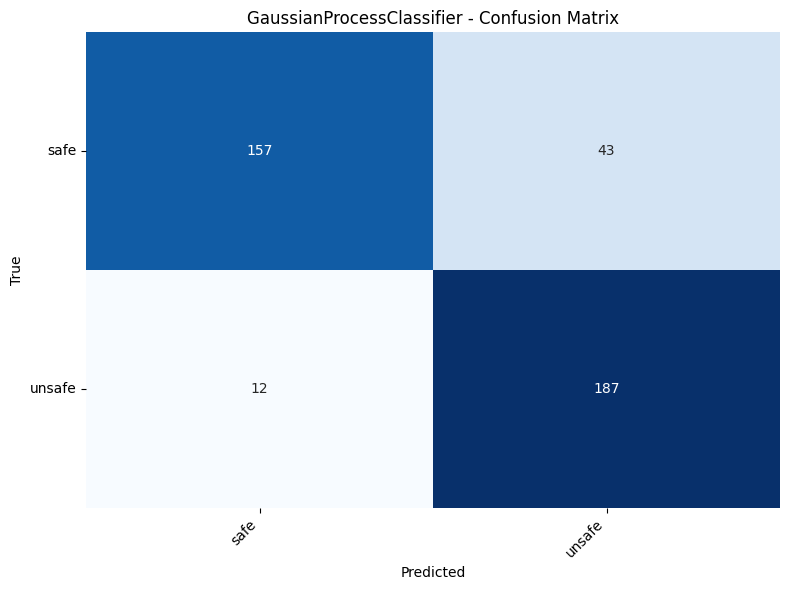

In [13]:
from sklearn.gaussian_process import GaussianProcessClassifier

model_path = r"models\GaussianProcessClassifier.pkl"

os.makedirs(os.path.dirname(model_path), exist_ok=True)

if os.path.exists(model_path) and os.path.getsize(model_path) > 0:
    gp_clf = joblib.load(model_path)
    predict = gp_clf.predict(x_test)
    calculateMetrics("GaussianProcessClassifier", predict, y_test)

else:
    gp_clf =  GaussianProcessClassifier()
    gp_clf.fit(x_train, y_train)
    predict = gp_clf.predict(x_test)
    joblib.dump(gp_clf, model_path)
    calculateMetrics("GaussianProcessClassifier", predict, y_test)

# Decision Tree Classifier


===  DecisionTreeClassifier Overall ===
Accuracy  : 90.23%
Precision : 90.27%
Recall    : 90.23%
F1-Score  : 90.22%


=== Classification Report ===
              precision    recall  f1-score   support

        safe       0.92      0.89      0.90       200
      unsafe       0.89      0.92      0.90       199

    accuracy                           0.90       399
   macro avg       0.90      0.90      0.90       399
weighted avg       0.90      0.90      0.90       399



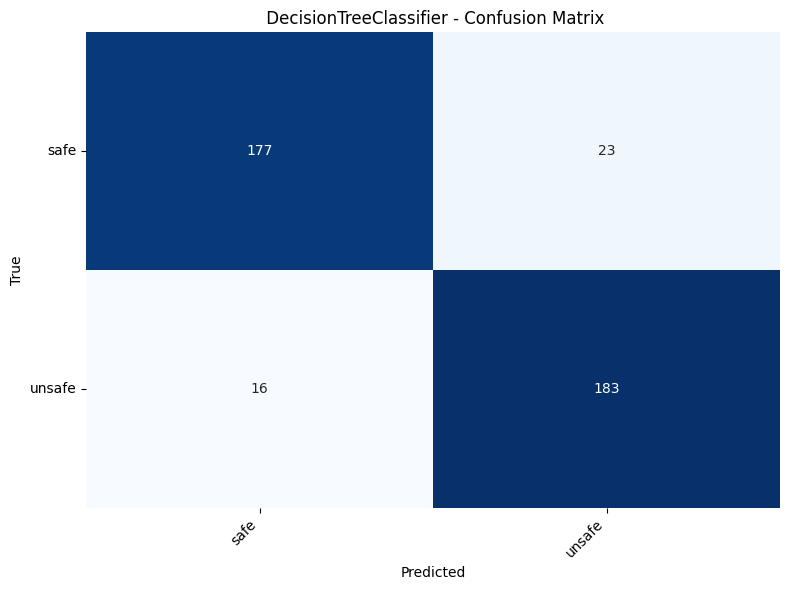

In [14]:
from sklearn.tree import DecisionTreeClassifier

model_path = r"models\DecisionTreeClassifier.pkl"

os.makedirs(os.path.dirname(model_path), exist_ok=True)

if os.path.exists(model_path) and os.path.getsize(model_path) > 0:
    dt_clf = joblib.load(model_path)
    predict = dt_clf.predict(x_test)
    calculateMetrics(" DecisionTreeClassifier", predict, y_test)

else:
    dt_clf = DecisionTreeClassifier(max_depth=100)
    dt_clf.fit(x_train, y_train)
    predict = dt_clf.predict(x_test)
    joblib.dump(dt_clf, model_path)
    calculateMetrics(" DecisionTreeClassifier", predict, y_test)

In [15]:
def create_per_class_dataframes():
    if not metrics_overall:
        print("No models evaluated yet!")
        return None

    overall_df = pd.DataFrame(metrics_overall)
    overall_df = overall_df.set_index('Model')[['Accuracy', 'Precision', 'Recall', 'F1-Score']]
    
    print("\n" + "="*60)
    print("OVERALL MODEL COMPARISON")
    print("="*60)
    print(overall_df.round(4))
    print()

    class_dfs = {}
    for cls, records in class_metrics_storage.items():
        df = pd.DataFrame(records)
        df = df.set_index('Model')[['Precision', 'Recall', 'F1-Score']]
        
        var_name = cls.replace(" ", "_").replace("-", "_") + "_df"
        globals()[var_name] = df
        class_dfs[cls] = df   # key by original class name (more readable)

        print(f"{cls.upper()} CLASS PERFORMANCE".center(60))
        print("-" * 60)
        print(df.round(4))
        print()

    return overall_df, class_dfs
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 7)

def plot_overall_with_values():
    ax = overall_df.plot(kind='bar', width=0.8, edgecolor='black', alpha=0.9)
    plt.title('Overall Model Performance Comparison', fontsize=16, fontweight='bold', pad=20)
    plt.ylabel('Score (%)')
    plt.xlabel('Model')
    plt.ylim(0, 105)
    plt.xticks(rotation=30, ha='right')
    plt.legend(title='Metric', bbox_to_anchor=(1.02, 1), loc='upper left')
    plt.grid(axis='y', alpha=0.3)

    # Add values on top of bars
    for container in ax.containers:
        ax.bar_label(container, fmt='%.2f%%', padding=3, fontsize=10, fontweight='bold')

    plt.tight_layout()
    plt.show()


def plot_per_class_metric_universal(metric_name):
    # Reconstruct correct class names from the original storage (universal!)
    class_names = list(class_metrics_storage.keys())  # e.g., ['Cirriform Clouds', 'Clear Sky', ...]
    
    # Build DataFrame: rows = models, columns = clean class names
    data = pd.DataFrame()
    for cls in class_names:
        records = class_metrics_storage[cls]
        df = pd.DataFrame(records).set_index('Model')
        data[cls] = df[metric_name]

    # Ensure same model order as overall_df
    data = data.loc[overall_df.index]

    # Plot
    plt.figure()
    ax = data.plot(kind='bar', width=0.82, edgecolor='black', alpha=0.9)
    
    plt.title(f'{metric_name} per  Class', fontsize=16, fontweight='bold', pad=20)
    plt.ylabel(f'{metric_name} (%)')
    plt.xlabel('Model')
    plt.ylim(0, 105)
    plt.xticks(rotation=30, ha='right')
    plt.legend(title='Class', bbox_to_anchor=(1.02, 1), loc='upper left')
    plt.grid(axis='y', alpha=0.3)

    # Add value labels on top of every bar
    for container in ax.containers:
        ax.bar_label(container, fmt='%.2f%%', padding=3, fontsize=9.5, fontweight='bold')

    plt.tight_layout()
    plt.show()

In [16]:
 overall_df, class_dfs = create_per_class_dataframes()


OVERALL MODEL COMPARISON
                           Accuracy  Precision  Recall  F1-Score
Model                                                           
SVC                           85.46      85.48   85.47     85.46
 NearestCentroid              60.40      60.47   60.41     60.34
GaussianProcessClassifier     86.22      87.10   86.23     86.14
 DecisionTreeClassifier       90.23      90.27   90.23     90.22

                   SAFE CLASS PERFORMANCE                   
------------------------------------------------------------
                           Precision  Recall  F1-Score
Model                                                 
SVC                            86.22    84.5     85.35
 NearestCentroid               61.41    56.5     58.85
GaussianProcessClassifier      92.90    78.5     85.09
 DecisionTreeClassifier        91.71    88.5     90.08

                  UNSAFE CLASS PERFORMANCE                  
------------------------------------------------------------
        

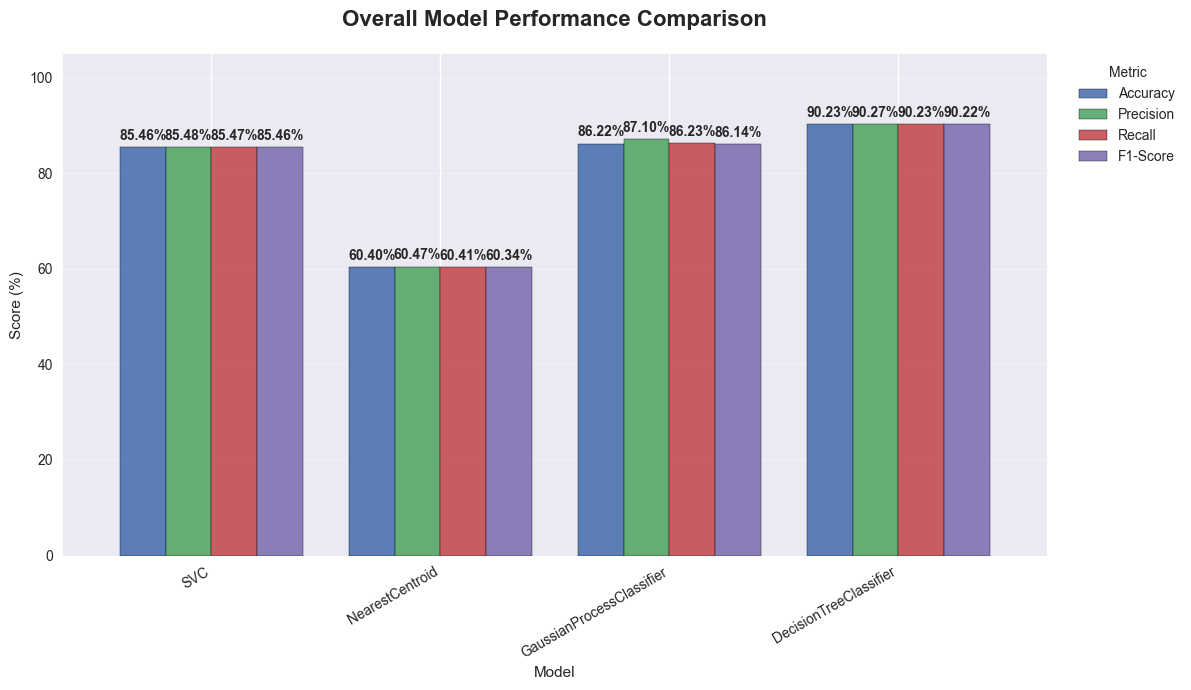

In [17]:
plot_overall_with_values()

<Figure size 1200x700 with 0 Axes>

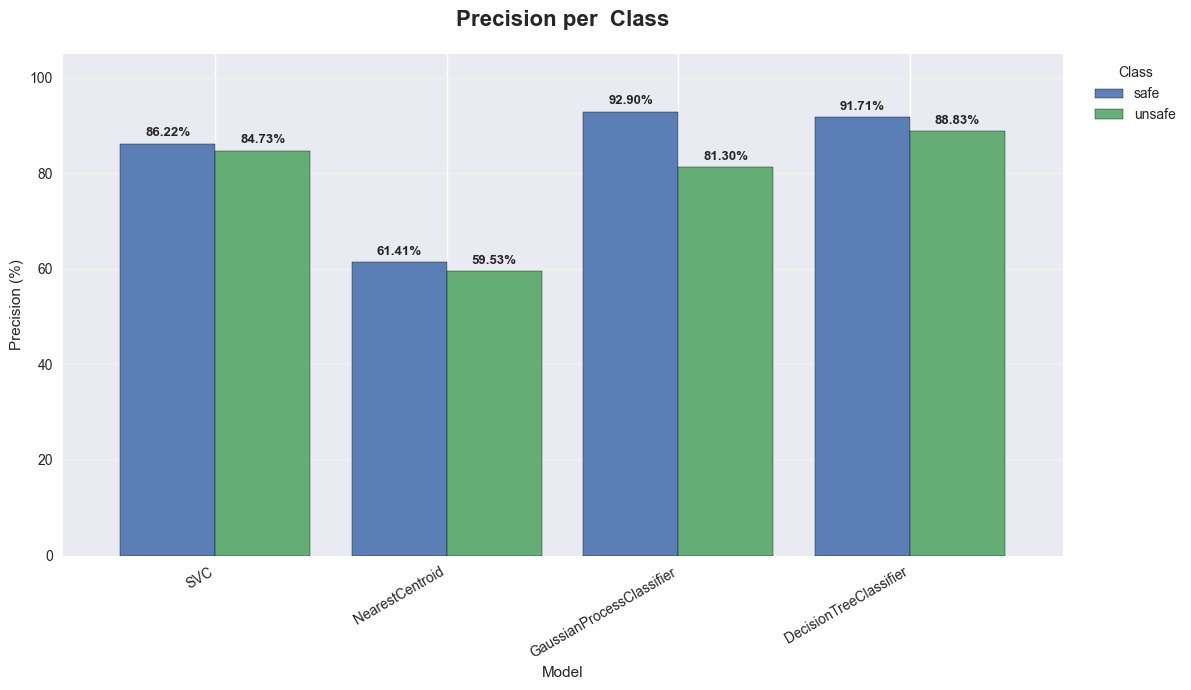

In [18]:
plot_per_class_metric_universal('Precision')

<Figure size 1200x700 with 0 Axes>

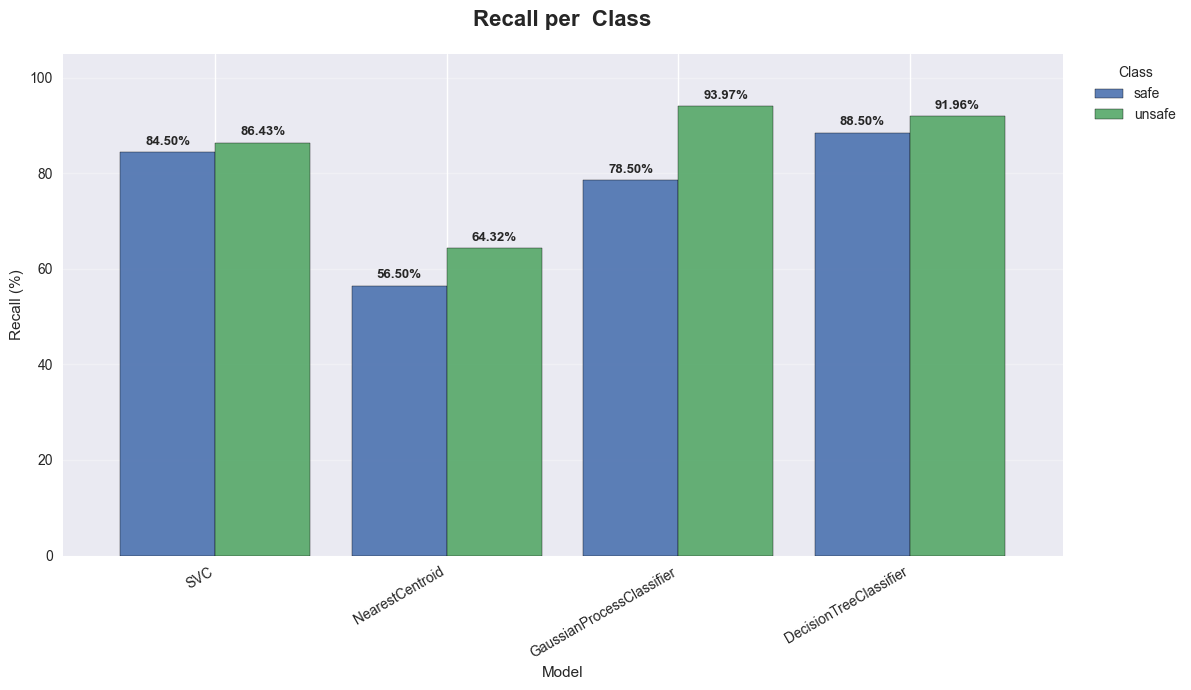

In [19]:
plot_per_class_metric_universal('Recall')

<Figure size 1200x700 with 0 Axes>

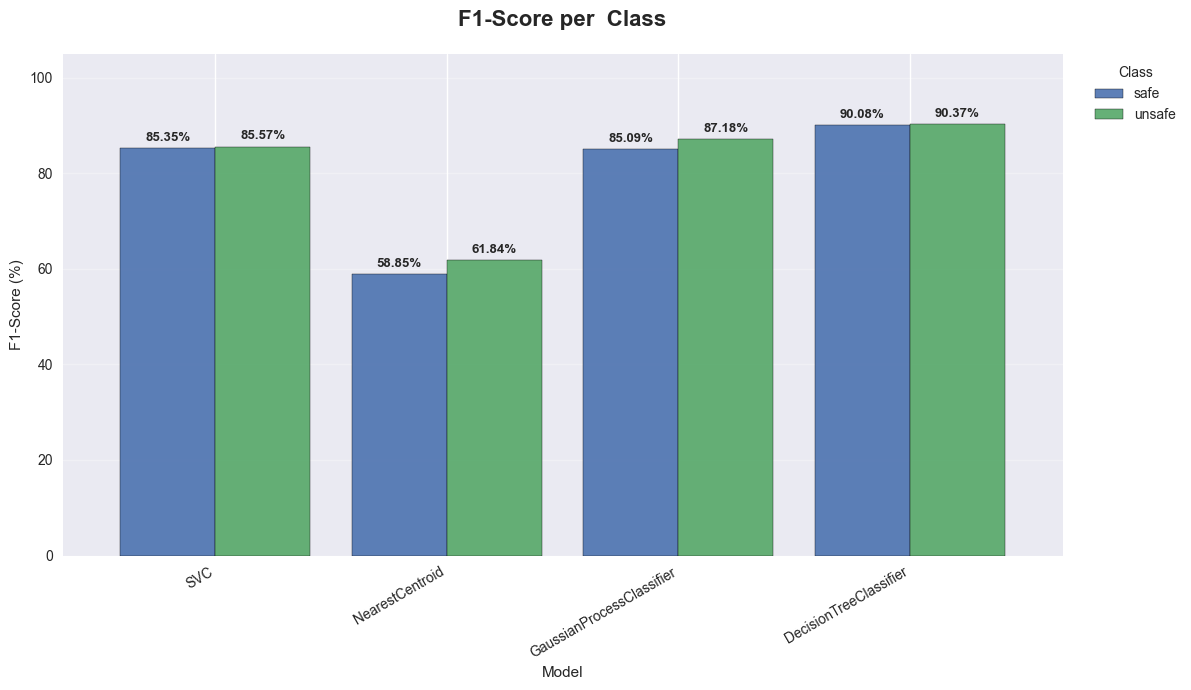

In [20]:
plot_per_class_metric_universal('F1-Score')

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import joblib
from skimage.feature import hog, local_binary_pattern
from tkinter import Tk
from tkinter.filedialog import askopenfilename

# ----------------------------
# Fixed feature extraction
# ----------------------------
IMG_SIZE = (64, 64)  # Must match training

def extract_features(img):
    """Extract HOG + LBP + HSV features, same as training."""
    img = cv2.resize(img, IMG_SIZE)

    # HOG (Shape)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    hog_feat = hog(
        gray,
        orientations=9,
        pixels_per_cell=(8, 8),
        cells_per_block=(2, 2),
        block_norm="L2-Hys"
    )

    # LBP (Texture)
    lbp = local_binary_pattern(gray, P=8, R=1, method="uniform")
    lbp_hist, _ = np.histogram(lbp.ravel(), bins=59, range=(0, 59))
    lbp_hist = lbp_hist.astype("float")
    lbp_hist /= (lbp_hist.sum() + 1e-6)

    # HSV (Color)
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h_hist = cv2.calcHist([hsv], [0], None, [30], [0, 180])
    s_hist = cv2.calcHist([hsv], [1], None, [32], [0, 256])
    v_hist = cv2.calcHist([hsv], [2], None, [32], [0, 256])
    color_hist = np.concatenate([h_hist, s_hist, v_hist]).flatten()
    color_hist /= (color_hist.sum() + 1e-6)

    return np.hstack([hog_feat, lbp_hist, color_hist])




# Test Prediction

In [ ]:
# ----------------------------
# Prediction function
# ----------------------------
def predict_image(model, categories):
    """Open a file dialog, select an image, and predict its class."""
    
    # Hide root tkinter window
    Tk().withdraw()
    
    # Open file selection dialog
    image_path = askopenfilename(
        title="Select an image",
        filetypes=[("Image files", "*.jpg *.jpeg *.png *.bmp")]
    )
    
    if not image_path:
        print("No image selected.")
        return None

    # Load image safely
    img_array = cv2.imread(image_path)
    if img_array is None:
        print(f"Error: Cannot read the image: {image_path}")
        return None

    # Extract features (resized to IMG_SIZE)
    features = extract_features(img_array).reshape(1, -1)

    # Safety check
    if features.shape[1] != model.n_features_in_:
        raise ValueError(
            f"Feature vector length {features.shape[1]} does not match "
            f"model expected {model.n_features_in_} features."
        )

    # Predict
    pred_idx = model.predict(features)[0]
    pred_label = categories[pred_idx]

    # Display image with predicted label
    plt.figure(figsize=(5,5))
    plt.imshow(cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB))
    plt.text(10, 10, f'Predicted: {pred_label}', color='blue', fontsize=12,
             weight='bold', backgroundcolor='white')
    plt.axis('off')
    plt.show()

    return pred_label

# ----------------------------
# Usage Example
# ----------------------------
# Load trained model
dt_model = joblib.load(r"models\DecisionTreeClassifier.pkl")

# Predict (opens a file dialog)
predicted_class = predict_image(dt_model, categories)
print("Predicted Class:", predicted_class)